## Batch norm and Initilization and activations

In [23]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

In [2]:
words = open('30k.txt', 'r').read().splitlines()

In [3]:
words[:5]

['the\t', 'of\t', 'and\t', 'to\t', 'a\t']

In [4]:
words = [''.join(ch for ch in word if ch != "\t") for word in words]

In [5]:
words[:5]

['the', 'of', 'and', 'to', 'a']

In [6]:
len(words)

30000

## Create the dataset

In [7]:
# The defaults are 
BLOCK_SIZE = 3

In [8]:
# create the mappings 

chars = sorted(list(set(''.join(word for word in words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [9]:
def build_dataset(data):
    X, Y = [], []

    for word in data:
        context = [0] * BLOCK_SIZE
        for ch in word + '.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"X.shape = {X.shape}   ||   Y.shape = {Y.shape}")

    return X, Y

In [10]:
import random
random.seed(1234)
random.shuffle(words)

Xtr, Ytr = build_dataset(words[:25000])
Xte, Yte = build_dataset(words[25000:27500])
Xdev, Ydev = build_dataset(words[27500:])

X.shape = torch.Size([196639, 3])   ||   Y.shape = torch.Size([196639])
X.shape = torch.Size([19717, 3])   ||   Y.shape = torch.Size([19717])
X.shape = torch.Size([19231, 3])   ||   Y.shape = torch.Size([19231])


In [11]:
Xtr[:5], Ytr[:5]

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 19],
         [ 0,  0,  0],
         [ 0,  0, 13]]),
 tensor([ 5, 19,  0, 13,  1]))

In [12]:
## Hard code the values of the hyperparameters

EMBEDDING_DIM = 10
NUM_NEURON = 100

In [13]:
## Define the default set of parameters and required initilization

g = torch.Generator().manual_seed(1234)

C = torch.rand((27, EMBEDDING_DIM), generator=g, requires_grad=True)  ## Embeddings

# Params for the 1st layer
W1 = torch.rand((EMBEDDING_DIM * BLOCK_SIZE, NUM_NEURON), generator=g, requires_grad=True)
b1 = torch.rand((NUM_NEURON, ), generator=g, requires_grad=True)

# params for the 2nd layer
W2 = torch.rand((NUM_NEURON, 27), generator=g, requires_grad=True)
b2 = torch.rand((27, ), generator=g, requires_grad=True)

params = [C, W1, b1, W2, b2]

In [14]:
print(f"C.shape: {C.shape}")
print(f"W1.shape: {W1.shape}")
print(f"b1.shape: {b1.shape}")
print(f"W2.shape: {W2.shape}")
print(f"b2.shape: {b2.shape}")

C.shape: torch.Size([27, 10])
W1.shape: torch.Size([30, 100])
b1.shape: torch.Size([100])
W2.shape: torch.Size([100, 27])
b2.shape: torch.Size([27])


In [15]:
# Hard Code the constants:

ITER = 200000
BATCH_SIZE = 32

In [56]:
## Create the model
lr = 1.0
lowest_loss_param = []
lowest_loss = torch.inf

for i in range(10000):
    # Forward pass
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE, ), generator=g)
    emb = C[Xtr[ix]]               # Embedding
    h = torch.tanh(emb.view(-1, EMBEDDING_DIM * BLOCK_SIZE) @ W1 + b1)     # First layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward Pass
    for p in params:
        p.grad = None
    loss.backward()

    # Update
    if i % (ITER // 3) == 0:
        lr /= 10
        print(f"LR = {lr}")
    for p in params:
        p.data += -lr * p.grad

    if loss < lowest_loss:
        lowest_loss = loss
        lowest_loss_param = [torch.clone(C), torch.clone(W1), torch.clone(b1), torch.clone(W2), torch.clone(b2)]

    # Print loss every 10 steps
    if i % (ITER / 10) == 0:
        print(f"Iter = {i} Loss = {loss.item()}")

LR = 0.1
Iter = 0 Loss = 2.0724616050720215


In [57]:
loss.data.item()

1.8973615169525146

In [58]:
lowest_loss.item()

1.418953537940979

In [59]:
len(lowest_loss_param)

5

In [64]:
# sample from the model
g = torch.Generator().manual_seed(1234)

for _ in range(20):
    
    out = []
    context = [0] * BLOCK_SIZE # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

s.
chand.
dationie.
sverated.
catorin.
treure.
pose.
gch.
bouthocstrew.
refaol.
inter.
unche.
armeniogotionfuropones.
precauten.
lowels.
stlateegeg.
setianestli.
extare.
oratinas.
burrentatious.


In [60]:
# ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE, ), generator=g)
emb = C[Xdev]               # Embedding
h = torch.tanh(emb.view(-1, EMBEDDING_DIM * BLOCK_SIZE) @ W1 + b1)     # First layer
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3203, grad_fn=<NllLossBackward0>)

In [61]:
# ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE, ), generator=g)
emb = lowest_loss_param[0][Xdev]               # Embedding
h = torch.tanh(emb.view(-1, EMBEDDING_DIM * BLOCK_SIZE) @ lowest_loss_param[1] + lowest_loss_param[2])     # First layer
logits = h @ lowest_loss_param[3] + lowest_loss_param[4]
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3085, grad_fn=<NllLossBackward0>)

In [53]:
emb = C[Xtr]               # Embedding
h = torch.tanh(emb.view(-1, EMBEDDING_DIM * BLOCK_SIZE) @ W1 + b1)     # First layer
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2472, grad_fn=<NllLossBackward0>)

## Next Part

In [62]:
## constants

VOCAB_SIZE = 27
BLOCK_SIZE = 3
EMBEDDING_DIM = 10
NEURON_CNT = 200

In [73]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
vocab_size = 27
block_size = 3

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [90]:
# same optimization as last time
max_steps = 50000
batch_size = 32
lossi = []
tanhi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  tanhi.append(h)
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/  50000: 2.4040
  10000/  50000: 2.4643
  20000/  50000: 2.2434
  30000/  50000: 2.1985
  40000/  50000: 2.0046


In [94]:
len(tanhi)

50000

In [64]:
# MAX_STEPS = 200000
# BATCH_SIZE = 32

# lossi = []

In [69]:
# for i in range(MAX_STEPS):
#     # Create random batches
#     ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE, ), generator=g)
    
#     # forward pass
#     emb = C[Xtr[ix]]
#     hpreact = emb.view(BATCH_SIZE, -1) @ W1

#     bnmeani = hpreact.mean(0, keepdim=True)
#     bnstdi = hpreact.std(0, keepdim=True)
#     hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
#     with torch.no_grad():
#         ## This is made for keeping the final mean and std for the inference purpose
#         bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
#         bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001

#     h = torch.tanh(hpreact)
#     logits = h @ W2 + b2
#     loss = F.cross_entropy(logits, Ytr[ix])

#     # Backward pass
#     for p in params:
#         p.grad = None
#     loss.backward()

#     # Update
#     lr = 0.1 if i < 100000 else 0.01
#     for p in params:
#         p.data += -lr * p.grad

#     lossi.append(loss.log10().item())

#     if i % (ITER / 10) == 0:
#         print(f"Iter: {i}   ||   Loss: {loss.item():.4f}")

Iter: 0   ||   Loss: 2.7262
Iter: 20000   ||   Loss: 2.1691
Iter: 40000   ||   Loss: 2.6445
Iter: 60000   ||   Loss: 3.0043
Iter: 80000   ||   Loss: 2.2995
Iter: 100000   ||   Loss: 2.7251
Iter: 120000   ||   Loss: 2.2826
Iter: 140000   ||   Loss: 2.5509
Iter: 160000   ||   Loss: 1.8672
Iter: 180000   ||   Loss: 2.4053


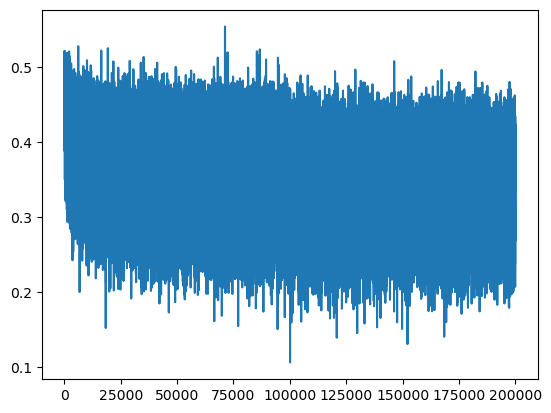

In [75]:
plt.plot(lossi)

In [78]:
# Calibrate the batch norm at the end

with torch.no_grad():
    emb = C[Xtr]
    print(emb.shape)
    hpreact = emb.view(emb.shape[0], -1) @ W1
    print(hpreact.shape)

    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    print(bnmean.shape)
    print(bnstd.shape)

torch.Size([196639, 3, 10])
torch.Size([196639, 200])
torch.Size([1, 200])
torch.Size([1, 200])


In [82]:
print(torch.sum(bnmean))
print(torch.sum(bnstd))

tensor(35.8808)
tensor(481.6537)


In [84]:
print(torch.sum(bnmean_running))
print(torch.sum(bnstd_running))

tensor(36.2818)
tensor(477.5368)


In [87]:
## Function to calculate Loss

@torch.no_grad()
def calcLoss(split):
    ds = {
        "train": (Xtr, Ytr),
        "test": (Xte, Yte), 
        "val": (Xdev, Ydev)
    }

    X, Y = ds[split]

    emb = C[X]
    hpreact = emb.view(emb.shape[0], -1) @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running - bnbias
    h = torch.tanh(hpreact)

    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    print(split, loss.item())

In [88]:
calcLoss('train')

train 2.5767860412597656


In [89]:
calcLoss('val')

val 2.647549867630005


## Pytorchifying